In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from sklearn.metrics import roc_auc_score

Kaggle Diabetes Prediction Competition:

This dataset contains patient records designed for diabetes risk prediction, with features based on demographics, lifestyle habits, family history, and clinical measurements that are well-established indicators of diabetes risk. All data is generated using statistical distributions inspired by real-world medical research.

In [ ]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [41]:
df_train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [42]:
print(df_train.shape, df_test.shape)

(700000, 26) (300000, 25)


#### 1. Feature Engineering
In clinical practice, many indicators are interpreted using diagnostic thresholds (e.g. normal / borderline / high-risk) rather than raw continuous values. These cut-offs often reflect meaningful physiological boundaries and are widely used in screening and diagnosis.

Motivated by this, we engineer **threshold-based risk flags** that indicate whether a patient’s measurements fall into unhealthy ranges. Such features provide clearer “risk signals” and help models learn non-linear effects and high-risk interactions.

Thresholds are derived in two ways:
1. **Data-driven cut-offs** inferred from SHAP dependence trends during EDA  
2. **Clinically established cut-offs** (e.g., BMI categories)

In [ ]:
# 1. Physical activity bins
# SHAP: <100 low activity, 100-250 healthy, 250 benefits level off

df_train["physical_activity_cat"] = pd.cut(
    df_train["physical_activity_minutes_per_week"],
    bins = [-1, 100, 250, 10000],
    labels = [0, 1, 2]
)

df_test["physical_activity_cat"] = pd.cut(
    df_test["physical_activity_minutes_per_week"],
    bins = [-1, 100, 250, 10000],
    labels = [0, 1, 2]
)

# Inactive indicator
df_train['inactive'] = (df_train['physical_activity_minutes_per_week'] < 150)
df_test['inactive'] = (df_test['physical_activity_minutes_per_week'] < 150)

In [44]:
df_train.groupby(['physical_activity_cat'], as_index = False)['diagnosed_diabetes'].mean()
# diabetes rate decrease with higher cat

/tmp/ipython-input-3627894906.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby(['physical_activity_cat'], as_index = False)['diagnosed_diabetes'].mean()


,physical_activity_cat,diagnosed_diabetes
0,0,0.659256
1,1,0.509218
2,2,0.326110


In [ ]:
# 2. BMI bins
# Based on clinical BMI range classifications: <18 healthy, 18-25 moderately overweight, 25-30 overweight, >30 severely overweight/obese

df_train["bmi_cat"] = pd.cut(
    df_train["bmi"],
    bins = [-1, 18, 25, 30, 10000],
    labels = [0, 1, 2, 3]
)

df_train['obese'] = (df_train['bmi'] >= 30)

df_test["bmi_cat"] = pd.cut(
    df_test["bmi"],
    bins = [-1, 18, 25, 30, 10000],
    labels = [0, 1, 2, 3]
)

df_test['obese'] = (df_test['bmi'] >= 30)

In [46]:
df_train.groupby(['bmi_cat'], as_index = False)['diagnosed_diabetes'].mean()
# diabetes rate increase with higher bmi

/tmp/ipython-input-2069359798.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby(['bmi_cat'], as_index = False)['diagnosed_diabetes'].mean()


,bmi_cat,diagnosed_diabetes
0,0,0.473596
1,1,0.574108
2,2,0.645550
3,3,0.724862


In [ ]:
# Inactive x obese interactions

df_train['inactive_obese'] = (df_train['obese'] & df_train['inactive'])
df_test['inactive_obese'] = (df_test['obese'] & df_test['inactive'])

In [ ]:
# 3. BP and Hypertension indicators

df_train['hypertension'] = ((df_train['systolic_bp'] > 130) | (df_train['diastolic_bp'] > 90))
df_test['hypertension'] = ((df_test['systolic_bp'] > 130) | (df_test['diastolic_bp'] > 90))

df_train['low_diastolic'] = (df_train['diastolic_bp'] < 60)
df_test['low_diastolic'] = (df_test['diastolic_bp'] < 60)

In [49]:
df_train.groupby(['hypertension'], as_index = False)['diagnosed_diabetes'].mean()

,hypertension,diagnosed_diabetes
0,False,0.612058
1,True,0.707844


In [ ]:
# 4. Sleep

df_train['short_sleep'] = (df_train['sleep_hours_per_day'] < 6)
df_test['short_sleep'] = (df_test['sleep_hours_per_day'] < 6)

df_train['long_sleep'] = (df_train['sleep_hours_per_day'] > 8.5)
df_test['long_sleep'] = (df_test['sleep_hours_per_day'] > 8.5)

In [51]:
df_train.groupby(['short_sleep', 'physical_activity_cat'], as_index = False)['diagnosed_diabetes'].mean()
# small effect while interacting with other features

/tmp/ipython-input-3359666197.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby(['short_sleep', 'physical_activity_cat'], as_index = False)['diagnosed_diabetes'].mean()


,short_sleep,physical_activity_cat,diagnosed_diabetes
0,False,0,0.659439
1,False,1,0.508965
2,False,2,0.327370
3,True,0,0.657888
4,True,1,0.510982
5,True,2,0.317839


In [52]:
df_train.groupby(['long_sleep', 'obese'], as_index = False)['diagnosed_diabetes'].mean()
# small effect while interacting with other features

,long_sleep,obese,diagnosed_diabetes
0,False,False,0.614990
1,False,True,0.722885
2,True,False,0.611820
3,True,True,0.733333


In [ ]:
# 5. Cholesterol indicators

df_train['low_hdl'] = (
    ((df_train['gender'] == 'Male') & (df_train['hdl_cholesterol'] < 40)) |
    ((df_train['gender'] != 'Male') & (df_train['hdl_cholesterol'] < 50))
)

df_test['low_hdl'] = (
    ((df_test['gender'] == 'Male') & (df_test['hdl_cholesterol'] < 40)) |
    ((df_test['gender'] != 'Male') & (df_test['hdl_cholesterol'] < 50))
)

df_train['high_triglycerides'] = (df_train['triglycerides'] > 150)
df_test['high_triglycerides'] = (df_test['triglycerides'] > 150)

df_train['high_ldl'] = (df_train['ldl_cholesterol'] > 130)
df_test['high_ldl'] = (df_test['ldl_cholesterol'] > 130)

df_train['high_cholesterol'] = (df_train['cholesterol_total'] > 200)
df_test['high_cholesterol'] = (df_test['cholesterol_total'] > 200)

# high blood cholesterol threshold for diabetic patients
df_train['diabetic_dyslipidemia'] = ((df_train['low_hdl']) & (df_train['high_triglycerides']))
df_test['diabetic_dyslipidemia'] = ((df_test['low_hdl']) & (df_test['high_triglycerides']))

In [54]:
df_train.groupby(['diabetic_dyslipidemia'], as_index = False)['diagnosed_diabetes'].mean()

,diabetic_dyslipidemia,diagnosed_diabetes
0,False,0.620450
1,True,0.722109


In [ ]:
# 6. Screen time indicators

df_train["high_screen_time"] = (df_train["screen_time_hours_per_day"] >= 8)
df_test["high_screen_time"]  = (df_test["screen_time_hours_per_day"]  >= 8)

df_train["sedentary_risk"] = (
    (df_train["high_screen_time"]) &
    (df_train["inactive"])
)

df_test["sedentary_risk"] = (
    (df_test["high_screen_time"]) &
    (df_test["inactive"])
)

In [56]:
df_train.groupby(['sedentary_risk'], as_index = False)['diagnosed_diabetes'].mean()
# slight increase in risk

,sedentary_risk,diagnosed_diabetes
0,False,0.618494
1,True,0.648945


In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   id                                  700000 non-null  int64   
 1   age                                 700000 non-null  int64   
 2   alcohol_consumption_per_week        700000 non-null  int64   
 3   physical_activity_minutes_per_week  700000 non-null  int64   
 4   diet_score                          700000 non-null  float64 
 5   sleep_hours_per_day                 700000 non-null  float64 
 6   screen_time_hours_per_day           700000 non-null  float64 
 7   bmi                                 700000 non-null  float64 
 8   waist_to_hip_ratio                  700000 non-null  float64 
 9   systolic_bp                         700000 non-null  int64   
 10  diastolic_bp                        700000 non-null  int64   
 11  heart_rate   

#### 2 Baseline models

We train multiple baselines with complementary strengths:
- **Logistic Regression (LR)**: interpretable linear reference model
- **Random Forest (RF)**: tree-based bagging model that captures threshold effects and interactions
- **CatBoost**: strong tabular model, handles categorical / indicator features well
- **LightGBM (LGBM)**: efficient gradient boosting model for learning complex non-linear trends

Training procedure:
1. **Add engineered features**
2. **Preprocessing (LR/RF only)**: imputation + scaling for numeric features, encoding for categorical features  
   (CatBoost/LGBM require minimal preprocessing due to native handling)
3. **Stratified 3-fold CV** to generate out-of-fold (OOF) predictions
4. Evaluate using **ROC-AUC**, and compare feature importance (using CatBoost) against the baseline without feature engineering

In [64]:
# 1. Prepare data

# Split data into X, y, X_test
drop_cols = ['id', 'diagnosed_diabetes']

X = df_train.drop(columns=drop_cols, errors='ignore')
y = df_train['diagnosed_diabetes']

X_test = df_test.drop(columns=drop_cols, errors='ignore')

# List of features
ordinal_cat_features = ["income_level", "education_level"]
ord_feature_categories = [
    ["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"],
    ["No formal", "Highschool", "Graduate", "Postgraduate"]
]

# Identify categorical features (but keep as object/bool in dataframe)
cat_like = set(X.select_dtypes(include=["bool", "object", "category"]).columns)
cat_like |= set(["cardiovascular_history", "hypertension_history", "family_history_diabetes"])
onehot_cat_features = list(cat_like - set(ordinal_cat_features))
cat_features = ordinal_cat_features + onehot_cat_features
num_features = [f for f in X.columns if f not in cat_features]

# IMPORTANT: Convert categorical columns back to object dtype for sklearn
# sklearn pipelines work better with object dtype than pandas category dtype
for col in cat_features:
    if col in X.columns:
        # Convert bool to string, keep category/object as object
        if X[col].dtype == 'bool':
            X[col] = X[col].astype(str)
            X_test[col] = X_test[col].astype(str)
        elif X[col].dtype.name == 'category':
            X[col] = X[col].astype(object)
            X_test[col] = X_test[col].astype(object)


# Init pipelines
ord_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown = 'use_encoded_value', categories=ord_feature_categories, unknown_value = -1))
])

ohe_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])

num_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'median')),
    ('scale', StandardScaler())

])

col_trans = ColumnTransformer(transformers = [
    ('ord_pipeline', ord_pipeline, ordinal_cat_features),
    ('ohe_pipeline', ohe_pipeline, onehot_cat_features),
    ("num_pipeline", num_pipeline, num_features)
    ], remainder = 'drop')


In [65]:
# 2. Model training
# a. Logistic Regression
params_lr = {
    "max_iter": 2000,
    "random_state": 5,
    "class_weight": "balanced",
    "solver": "liblinear",
    "penalty": "l2",
    "n_jobs": -1
}

lr = Pipeline(steps=[
    ("prep", col_trans),
    ("clf", LogisticRegression(**params_lr))
])

In [66]:
# b. Random Forest
params_rf = {
    "n_estimators": 500,
    "random_state": 5,
    "class_weight": "balanced_subsample",
    "min_samples_leaf": 20,
    "max_features": "sqrt",
    "n_jobs": -1
}

rf = Pipeline(steps=[
    ("prep", col_trans),
    ("clf", RandomForestClassifier(**params_rf))
])

In [67]:
# c. Catboost
params_catboost = {
      "iterations": 2000,
      "loss_function": "Logloss",
      "eval_metric": "Logloss",
      "random_seed": 5,
      "verbose": False,
      "auto_class_weights": "Balanced",
      "task_type": 'GPU',
      "devices": '0'
}

In [68]:
# d. LightGBM
params_lgb = {
    "num_iterations": 2000,
    "device_type": "gpu",
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'seed': 5,
    'is_unbalance': True
}

In [70]:
# 3. CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)
cv_scores = {
    "lr": [],
    "rf": [],
    "catboost": [],
    "lgb": []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f'Training fold {fold}...')
    X_train_fold = X.iloc[train_idx].copy()
    y_train_fold = y.iloc[train_idx].copy()
    X_val_fold = X.iloc[val_idx].copy()
    y_val_fold = y.iloc[val_idx].copy()

    # a. Logistic regression
    lr.fit(X_train_fold, y_train_fold)
    preds_lr = lr.predict_proba(X_val_fold)[:, 1]
    cv_scores["lr"].append(roc_auc_score(y_val_fold, preds_lr))
    print(f'Fold {fold} LR complete.')

    # b. Random forest
    rf.fit(X_train_fold, y_train_fold)
    preds_rf = rf.predict_proba(X_val_fold)[:, 1]
    cv_scores["rf"].append(roc_auc_score(y_val_fold, preds_rf))
    print(f'Fold {fold} RF complete.')

    # c. Catboost
    # Convert object dtypes to category
    X_train_boost = X_train_fold.copy()
    X_val_boost = X_val_fold.copy()
    for col in cat_features:
        if col in X_train_boost.columns:
            X_train_boost[col] = X_train_boost[col].astype('category')
            X_val_boost[col] = X_val_boost[col].astype('category')

    train_pool = Pool(X_train_boost, y_train_fold, cat_features=cat_features)
    val_pool = Pool(X_val_boost, y_val_fold, cat_features=cat_features)

    model_cat = CatBoostClassifier(**params_catboost)
    model_cat.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=100
    )
    preds_cat = model_cat.predict_proba(val_pool)[:, 1]
    cv_scores["catboost"].append(roc_auc_score(y_val_fold, preds_cat))
    print(f'Fold {fold} catboost complete.')

    # d. LightGBM
    dtrain = lgb.Dataset(
        X_train_boost,
        label=y_train_fold,
        categorical_feature=cat_features,
        free_raw_data=False
    )
    dvalid = lgb.Dataset(
        X_val_boost,
        label=y_val_fold,
        categorical_feature=cat_features,
        reference=dtrain,
        free_raw_data=False
    )

    model_lgb = lgb.train(
        params_lgb,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    print(f'Fold {fold} LGB complete.')

    preds_lgb = model_lgb.predict(X_val_boost, num_iteration=model_lgb.best_iteration)
    cv_scores["lgb"].append(roc_auc_score(y_val_fold, preds_lgb))
    print(f"Fold {fold} completed.")

Training fold 1...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 1 LR complete.
Fold 1 RF complete.
Fold 1 catboost complete.
Fold 1 LGB complete.
Fold 1 completed.
Training fold 2...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 2 LR complete.
Fold 2 RF complete.
Fold 2 catboost complete.
Fold 2 LGB complete.
Fold 2 completed.
Training fold 3...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Fold 3 LR complete.
Fold 3 RF complete.
Fold 3 catboost complete.
Fold 3 LGB complete.
Fold 3 completed.


In [ ]:
for k, scores in cv_scores.items():
    print(f"{k}: mean AUC = {float(np.mean(scores)):.6f} | std = {float(np.std(scores)):.6f}")

# LGB performs best with raw features + clinical indicators, slight improvement for catboost.
# Gradient boosting models perform better than simple models in general

lr: mean AUC = 0.695020 | std = 0.000367
rf: mean AUC = 0.701064 | std = 0.000347
catboost: mean AUC = 0.723791 | std = 0.000489
lgb: mean AUC = 0.725294 | std = 0.000474


In [72]:
# 4. Feature importance using catboost
full_pool = Pool(X, y, cat_features=cat_features)

full_model = CatBoostClassifier(**params_catboost)
full_model.fit(full_pool)

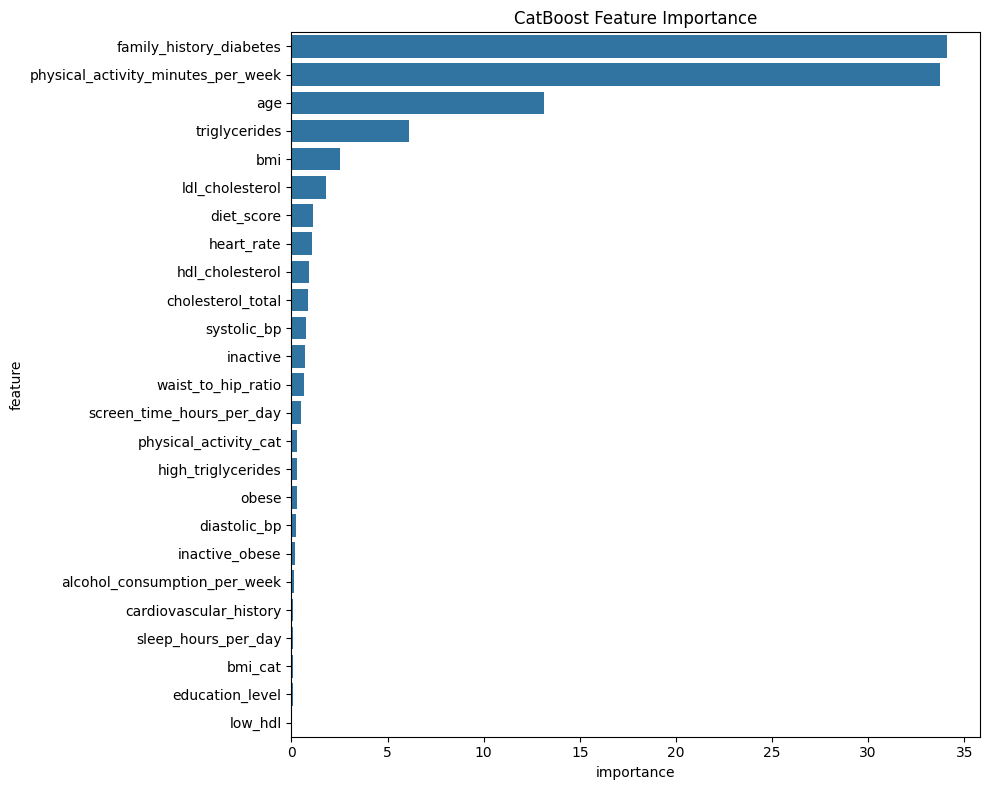

In [ ]:
imp_vals = full_model.get_feature_importance(full_pool, type="FeatureImportance")
imp_df = (
    pd.DataFrame({"feature": X.columns, "importance": imp_vals})
      .sort_values("importance", ascending=False)
)

top_n = 25
plt.figure(figsize=(10, 8))
sns.barplot(data=imp_df.head(top_n), x="importance", y="feature")
plt.title(f"CatBoost Feature Importance")
plt.tight_layout()
plt.show()

# Family history, physical activity still dominates in importance, slight improvement in catboost AUC with clinical indicators
# Engineered features boost performance of models slightly